In [107]:
%load_ext autoreload
%autoreload 2

from src.models.gps import GPS
from src.models.gcn import GCN
from src.models.explainer.explainer_pipeline import ExplainerPipeline
from src.models.explainer.gnn_explainer import GNNExplainer
from src.data import loader

import networkx as nx

from torch_geometric.explain import ModelConfig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The node_mask and edge_mask attributes filter out nodes and edges belonging to motifs.

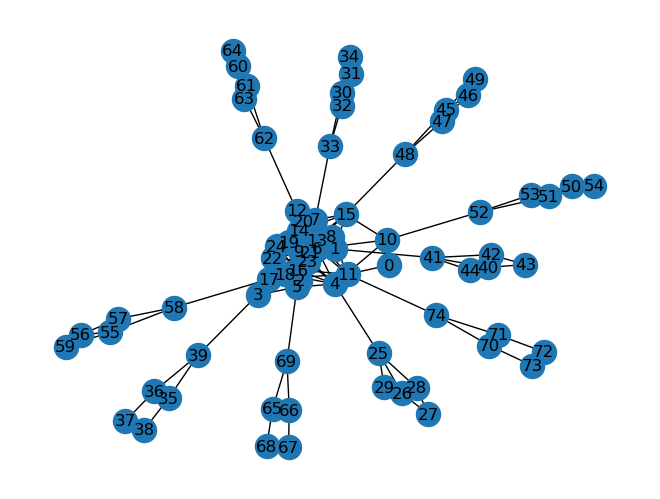

In [ ]:
data, num_classes, data_networkx = loader.load_clean_bashapes(num_nodes=25, num_edges=5, num_motifs=10, laplacian_eigenvector_dimensions=2)
nx.draw(data_networkx, with_labels=True)

In [113]:
gps_params = {
    'pe_channels': 2,
    'num_layers': 4,
    'hidden_channels': 4,
    'num_attention_heads': 1,
    'observe_attention': True
}

gcn_params = {
    "hidden_channels": 20,
    "num_layers": 3
}

explainer_params = {
    'explanation_type': 'model',
    'node_mask_type': 'attributes',
    'edge_mask_type': 'object',
    'model_config': ModelConfig(
        mode='multiclass_classification',
        task_level='node',
        return_type='raw',
    )
}

explainer_pipeline = ExplainerPipeline(data, num_classes, GCN, GNNExplainer, model_params=gcn_params, explainer_params=explainer_params, epochs=4000)
explainer_pipeline.get_accuracies()

100%|██████████| 4000/4000 [00:09<00:00, 410.25it/s]


Train accuracy: 0.85
Test accuracy: 0.8666666666666667


In [123]:
explainer_pipeline.explain(26, laplacian_eigenvector_pe=explainer_pipeline.data.laplacian_eigenvector_pe)

100%|██████████| 100/100 [00:00<00:00, 352.53it/s]


In [124]:
explanation = explainer_pipeline.explanations[26]
explanation

Explanation(node_mask=[75, 1], edge_mask=[292], prediction=[75, 4], target=[75], index=[1], x=[75, 1], edge_index=[2, 292], laplacian_eigenvector_pe=[75, 2])

In [126]:
explanation.edge_mask

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

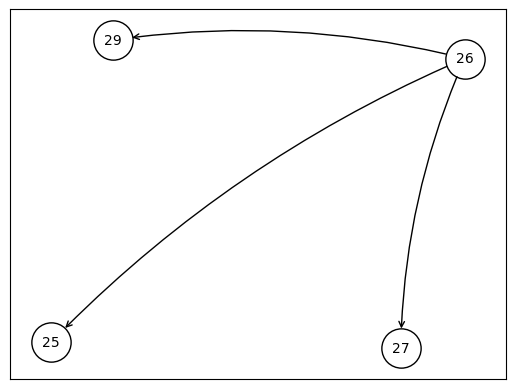

In [125]:
explanation.visualize_graph()

In [105]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.nn import GCN
from torch_geometric.utils import k_hop_subgraph

data

idx = torch.arange(data.num_nodes)
train_idx, test_idx = train_test_split(idx, train_size=0.8, stratify=data.y)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(data.num_node_features, hidden_channels=20, num_layers=3,
            out_channels=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[train_idx], data.y[train_idx])
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(dim=-1)

    train_correct = int((pred[train_idx] == data.y[train_idx]).sum())
    train_acc = train_correct / train_idx.size(0)

    test_correct = int((pred[test_idx] == data.y[test_idx]).sum())
    test_acc = test_correct / test_idx.size(0)

    return train_acc, test_acc


pbar = tqdm(range(1, 2001))
for epoch in pbar:
    loss = train()
    if epoch == 1 or epoch % 200 == 0:
        train_acc, test_acc = test()
        pbar.set_description(f'Loss: {loss:.4f}, Train: {train_acc:.4f}, '
                             f'Test: {test_acc:.4f}')
pbar.close()
model.eval()

for explanation_type in ['phenomenon', 'model']:
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=300),
        explanation_type=explanation_type,
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='node',
            return_type='raw',
        ),
    )

    # Explanation ROC AUC over all test nodes:
    targets, preds = [], []
    node_indices = range(400, data.num_nodes, 5)
    for node_index in tqdm(node_indices, leave=False, desc='Train Explainer'):
        target = data.y if explanation_type == 'phenomenon' else None
        explanation = explainer(data.x, data.edge_index, index=node_index,
                                target=target)

        _, _, _, hard_edge_mask = k_hop_subgraph(node_index, num_hops=3,
                                                 edge_index=data.edge_index)

        targets.append(data.edge_mask[hard_edge_mask].cpu())
        preds.append(explanation.edge_mask[hard_edge_mask].cpu())

    auc = roc_auc_score(torch.cat(targets), torch.cat(preds))
    print(f'Mean ROC AUC (explanation type {explanation_type:10}): {auc:.4f}')

Loss: 0.6762, Train: 0.8167, Test: 0.7333: 100%|██████████| 2000/2000 [00:03<00:00, 650.79it/s]


RuntimeError: torch.cat(): expected a non-empty list of Tensors